# Powertrain for UAV

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from scipy.interpolate import interp1d

nsteps = lambda x: np.linspace(0, x, 500)

### Battery profile

In [60]:
def get_battery_curves(soc_ocv_file, R0_degradation_file, Q_degradation_file):
    """
        @brief: gets the degradation profile (predefined curves) for the battery
        
        @input:
            soc_ocv_file: a csv file containing the soc_ocv relationship as a column vector
            R0_degradation_file: a csv file containing the R0 degradation curve as a column vector
            Q_degradation_file: a csv file containing the Q degradation curve as a column vector
        
        @output:
            a dictionary mapping of degradation curves with ["soc_ocv", "R0_degradation", "Q_degradation"] keys
    """    
    soc_ocv = []
    R0_degradation = []
    Q_degradation = []
    
    with open(soc_ocv_file, newline='') as f:
        soc_ocv = list(csv.reader(f))
    soc_ocv = np.asarray(soc_ocv).astype(np.float)
    
    with open(R0_degradation_file, newline='') as f:
        R0_degradation = list(csv.reader(f))
    R0_degradation = np.asarray(R0_degradation).astype(np.float)
    
    with open(Q_degradation_file, newline='') as f:
        Q_degradation = list(csv.reader(f))
    Q_degradation = np.asarray(Q_degradation).astype(np.float)
    
    return {"soc_ocv": soc_ocv, "R0_degradation": R0_degradation, "Q_degradation": Q_degradation}

In [61]:
battery_curves = get_battery_curves('soc_ocv.csv', 'R0_degradation.csv', 'Q_degradation.csv')

### Base Battery Cell

In [64]:
class Battery:
    def __init__(self, *args, **kwargs):
        if(len(kwargs) == 0):
            self.soc_ocv = np.zeros((1,1))
            self.R0_degradation = np.zeros((1,1))
            self.Q_degradation = np.zeros((1,1))
        else:
            self.soc_ocv = kwargs["soc_ocv"]
            self.R0_degradation = kwargs["R0_degradation"]
            self.Q_degradation = kwargs["Q_degradation"]
        self.soc = 1.0
        self.Ir = 0
        self.h = 0
        self.M0 = .0019
        self.M = .0092
        self.R0 = .0112
        self.R = 2.83e-4
        self.Q = 3.8695
        self.n = .9987
        self.G = 163.4413
        self.v0 = 4.2
        self.eod = 3.04
        self.RC = 3.6572
        self.ocv = self.v0
    
    def step(self, dt, current):
        raise NotImplementedError
        
    def add_profile(self, **profile):
        self.soc_ocv = profile["soc_ocv"]
        self.R0_degradation = profile["R0_degradation"]
        self.Q_degradation = profile["Q_degradation"]

### The Continuous Battery Cell

In [65]:
class ContinuousBatteryCell(Battery):
    def __init__(self, *args, **kwargs):
        super(ContinuousBatteryCell, self).__init__(*args, **kwargs)
        print("continuous battery cell")

In [191]:
cbcell = ContinuousBatteryCell(**battery_curves)
plt.plot(cbcell.soc_ocv)
plt.show()

In [203]:
def get_poly(curve, pwr):
    x_poly = np.arange(0, len(curve))
    y_poly = np.polyfit(x_poly, curve, pwr)
    return y_poly



In [204]:
z_coeff = get_poly(cbcell.soc_ocv, 5)
print(z_coeff)

[[ 1.43512460e-09]
 [-4.33488147e-07]
 [ 5.21563505e-05]
 [-3.10719077e-03]
 [ 9.14558429e-02]
 [ 2.98893868e+00]]


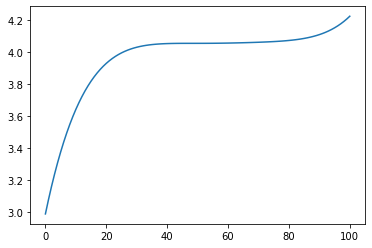

[4.0511068]


In [200]:
z_poly = np.polyval(soc_ocv_poly, xz_poly)
plt.plot(z_poly)
plt.show()
z = np.polyval(soc_ocv_poly, 40.345345435)
print(z)

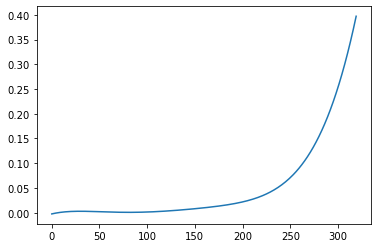

[0.00261442]


In [201]:
xr_poly = np.arange(0, len(cbcell.R0_degradation))
R0_degradation_poly = np.polyfit(xr_poly, cbcell.R0_degradation, 5)
r_poly = np.polyval(R0_degradation_poly, xr_poly)
plt.plot(r_poly)
plt.show()
r = np.polyval(R0_degradation_poly, 40.345345435)
print(r)

### The Discrete Battery Cell

In [17]:
class DiscreteBatteryCell(Battery):
    def __init__(self, *args, **kwargs):
        super(DiscreteBatteryCell, self).__init__(*args, **kwargs)
        
    def get_ocv(self):
        if(self.soc < 0.0):
            self.soc = 0
        elif(self.soc > 1.0):
            self.soc = 1.0
        idx = int(np.ceil(self.soc*100))
        if(idx > 101):
            idx = 101
        elif(idx < 1):
            idx = 1
        return self.soc_ocv[idx]
        
    def step(self, dt, current):
        RC = np.exp(-dt/abs(self.RC))
        H = np.exp(-abs(self.n*current*self.G*dt/(3600*self.Q)))
        self.Ir = RC*self.Ir + (1-RC)*current
        self.h = H*self.h + (H-1)*np.sign(current)
        self.soc = self.soc - self.n*current/3600/self.Q
        self.ocv = self.get_ocv() + self.M*self.h + self.M0*np.sign(current) - self.R*self.Ir - self.R0*current

### The battery
- Something is off with the battery, need to double check the series / parallel configuration

In [17]:
class DiscreteBattery:
    def __init__(self, cells: DiscreteBatteryCell, wiring):
        self.cells = cells
        self.wiring = wiring
        self.v0 = self.cells[0].v0 if wiring == "parallel" else sum(cell.v0 for cell in self.cells)
        self.v0 = round(self.v0, 3)
        self.soc = 1.0
        self.ocv = self.v0
        self.eod = self.cells[0].eod if wiring == "parallel" else sum(cell.eod for cell in celf.cells)
        
    def step(self, dt, current):
        if(self.wiring == "parallel"):
            for cell in self.cells:
                cell.step(dt, current)
            self.soc = sum(cell.soc for cell in self.cells) / 3
            self.ocv = sum(cell.ocv for cell in self.cells) / 3
            

### test the cells and battery

In [18]:
cells = []
for i in range(0,3):
    cells.append(DiscreteBatteryCell(**battery_curves))
battery = DiscreteBattery(cells, "parallel")
cell = DiscreteBatteryCell(**battery_curves)

#### simulate the cell
- dt = 1 second, current = 3.8695
- the cell capacity is 3.8695 mAh, so, i should be ~3600 
- the cell asymptotically approaches the eod, so have to stop slightly above

In [19]:
i = 0
while(cell.ocv > (cell.eod * 1.005)):
    cell.step(1, 3.8695)
    i += 1
print(cell.ocv)
print(i)

[3.04926653]
3569


#### simulate the battery
- same as above, since the battery is configured as parallel cells

In [5308]:
i = 0
while(battery.ocv > (battery.eod * 1.005)):
    battery.step(1, 3.8695)
    i += 1
print(battery.ocv)
print(i)

### integration learning
quad(f, a, b)
- computes integral of f from a to b
- returns value, error estimate  

dblquad(f, a, b, gx, hx)
- computes integral of f from a to b on gy to hy
- returns value, error estimate


In [153]:
%matplotlib inline
from scipy.integrate import quad, ode, odeint
from scipy import random
#quad??

example: integrate 3x^2 + 1 dx from 0 to 1

In [149]:
def f(x):
    return 3.0*x**2 + 1

I = quad(f, 0, 1)[0]
print(I)

def dxdt(t, x):
    return  -x / 10

integrator = ode(dxdt).set_integrator('vode', nsteps=500, method='bdf')

2.0


In [152]:
integrator.set_initial_value(y=100, t=0)
integrator.integrate(2, .1)

array([99.92933929])

In [36]:
def f(x, a, b):
    return np.sin(x**a) + b
    
x0 = 0
x1 = 5
a = 2
b = 3

I = quad(f, x0, x1, args=(a, b, ))[0]
print(I)

[0.00673795]


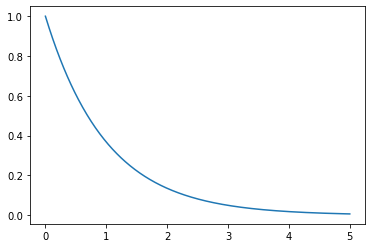

In [185]:
def dCdt(C, t, tau):
    return -C/tau

C0 = 1.0 

times = lambda x: np.linspace(0, x, 500)

tau0 = 1.0
x = times(5)
C = odeint(dCdt, C0, x, args=(tau0,))
print(C[-1])
plt.plot(x, C)


[3.13206926]


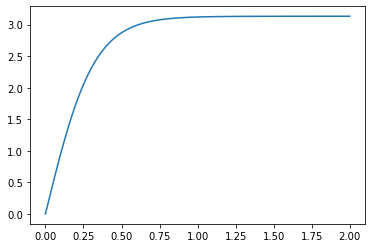

In [189]:
times = lambda x: np.linspace(0, x, 500)

def dvdt(v, t, g, c):
    return g - c*v**2

v0 = 0.0
g = 9.81
c = 1.0
t1 = times(2)
v = odeint(dvdt, v0, t1, args=(g,c,))
print(v[-1])
plt.plot(t1,v)


15.52791728116532


### integration thru monte carlo simulation

In [70]:
a = 0
b = np.pi
N = 1000
xrand = random.uniform(a, b, N)

def func(x):
    return np.sin(x)

I = 0.0

for i in range(N):
    I += func(xrand[i])
I = (b-a)/float(N)*I
print(I)

Iq = quad(func, a,b)[0]
print(Iq)

2.0238647968398333
2.0
